25


C:\Users\jbang\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [21:52:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Accuracy: 0.8223
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      5860
           1       0.66      0.39      0.49      1640

    accuracy                           0.82      7500
   macro avg       0.75      0.67      0.69      7500
weighted avg       0.81      0.82      0.80      7500


Final Training Log Loss: 0.3040
Final Test Log Loss: 0.4249


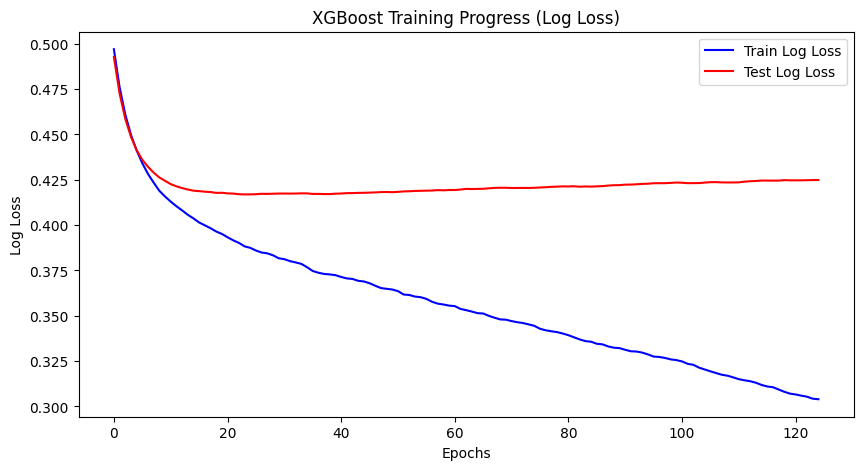

In [ ]:
#other defense applied to compare impact with respect to RAI used as a defense
%run /home/jui/thesis-code/Thesis-code/RAI-implementation/Baseline-model.ipynb

In [6]:
from art.estimators.classification import XGBoostClassifier
from art.attacks.evasion import ZooAttack
from art.estimators.classification import SklearnClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Select random 7500 samples using positional indexing
subset_indices = np.random.choice(len(y_train_og), 7500, replace=False)
X_train_subset = X_train_og.iloc[subset_indices]  # Use .iloc for positional indexing
y_train_subset = y_train_og[subset_indices]  # Direct positional indexing for NumPy array


def get_adversarial_examples(X_train_subset, pipeline, model):
    """
    Generate adversarial examples using the ZooAttack method.

    Args:
        X_train_subset (np.ndarray): Subset of training data (raw features).
        y_train_subset (np.ndarray): Corresponding labels for the subset.
        pipeline (Pipeline): The original pipeline containing preprocessing and model.

    Returns:
        np.ndarray: Adversarial examples.
    """
    # Extract the preprocessor and model from the pipeline
    preprocessor = pipeline.named_steps['preprocessor']

    # Preprocess the subset of training data using the pipeline's preprocessor
    X_train_subset_preprocessed = preprocessor.transform(X_train_subset)

    # Create ART classifier for XGBoost
    art_classifier = XGBoostClassifier(
        model=model,
        nb_features=X_train_subset_preprocessed.shape[1],
        nb_classes=2)

    # Create the ZooAttack instance
    zoo = ZooAttack(
        classifier=art_classifier,
        confidence=0.0,
        targeted=False,
        learning_rate=1e-1,
        max_iter=50,
        binary_search_steps=10,
        initial_const=1e-3,
        abort_early=True,
        use_resize=False,
        use_importance=False,
        nb_parallel=5,
        batch_size=1,
        variable_h=0.01
    )

    # Generate adversarial examples
    x_train_adv = zoo.generate(X_train_subset_preprocessed)

    return x_train_adv

In [ ]:
x_train_adv = get_adversarial_examples(X_train_subset, pipeline, model_baseline)
print(x_train_adv.shape)

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# Convert all datasets to NumPy arrays before training
xgb_model.fit(x_train_adv, y_train_subset,  verbose=False)

# Predictions on the test set (not the original or adversarial training data)
y_pred_test = xgb_model.predict(X_test)

# Compute accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {accuracy_test * 100:.2f}%")

# Confusion Matrix for test data
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [ ]:
# ---- STEP 5: Apply High-Confidence Defense to Adversarial Examples ----
y_probs_adv = xgb_model.predict_proba(x_train_adv)[:, 1]
threshold = 0.8  # Confidence threshold for filtering

# Apply high-confidence rule
y_pred_conf = np.where(y_probs_adv >= threshold, 1,
                       np.where(y_probs_adv <= (1 - threshold), 0, -1))  # -1 = abstain

mask = y_pred_conf != -1  # Mask the abstained predictions
x_adv_squeezed = x_train_adv[mask]  # Filter adversarial examples
y_pred_filtered = y_pred_conf[mask]  # Filter the corresponding predictions
y_test_filtered = y_train_subset[mask]  # Filter the corresponding true labels

xgb_model.fit(x_adv_squeezed, y_test_filtered,  verbose=False)

# Predictions on the test set (not the original or adversarial training data)
y_pred_test = xgb_model.predict(X_test)

# Compute accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set with High confidence defense: {accuracy_test * 100:.2f}%")

# Confusion Matrix for test data
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix for the test set
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()

In [7]:
def label_flip_attack(y_train: np.ndarray, flip_percent: float) -> np.ndarray:
    """
    Flip labels in y_train by a specified percentage.
    
    Args:
        y_train (np.ndarray): Original training labels.
        flip_percent (float): Percentage of labels to flip (0-100).

    Returns:
        np.ndarray: Poisoned labels with flipped values.
    """
    y_poisoned = y_train.copy()
    n_samples = len(y_train)
    n_flip = int((flip_percent / 100) * n_samples)  # Number of labels to flip
    
    flip_indices = np.random.choice(np.arange(n_samples), size=n_flip, replace=False)

    # Flip binary labels (assuming labels are 0 and 1)
    y_poisoned[flip_indices] = 1 - y_poisoned[flip_indices]  # Flip 0->1 and 1->0
    
    return y_poisoned



Accuracy on Test Set: 75.67%


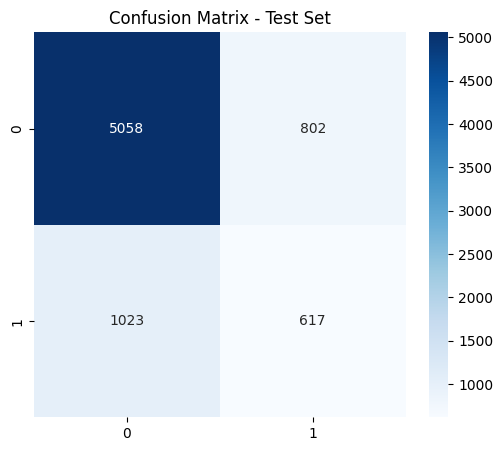

In [8]:
# Define the percentage of labels to flip
flip_percent = 35  # Flip 35% of labels

# Apply label flipping attack
y_train_poisoned = label_flip_attack(y_train_og, flip_percent)

# Step 2: Train model on poisoned labels
xgb_model.fit(X_train_og, y_train_poisoned, verbose=False)

# Step 3: Evaluate model on test set
y_pred_test = xgb_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on Test Set: {accuracy_test * 100:.2f}%")

# Step 4: Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()

Accuracy on Inlier Test Data: 0.76


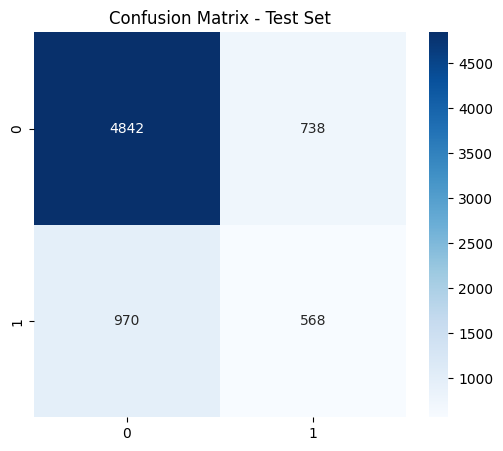

In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from copy import deepcopy

# Load your original training and test data
with open('train_data_base.pkl', 'rb') as f:
    X_train_full, y_train_full = pickle.load(f)

with open('test_data_base.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

# Preprocess the data
X_train_proc = pipeline.named_steps['preprocessor'].transform(X_train_full)
X_test_proc = pipeline.named_steps['preprocessor'].transform(X_test)

# Initialize the Isolation Forest model
iso = IsolationForest(contamination=0.05, random_state=42)

# Fit the Isolation Forest model to the training data (normal data)
iso.fit(X_train_proc)

# Flag potential outliers in the test set
test_outliers = iso.predict(X_test_proc)  # -1 = outlier, 1 = inlier

# Filter test set to keep only inliers
X_test_clean = X_test[test_outliers == 1]
y_test_clean = y_test[test_outliers == 1]

# Evaluate the model on the cleaned test set
y_pred_clean = xgb_model.predict(X_test_clean)
acc_clean = accuracy_score(y_test_clean, y_pred_clean)
print(f"Accuracy on Inlier Test Data: {acc_clean:.2f}")

cm_test = confusion_matrix(y_test_clean, y_pred_clean)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()